In [ ]:
!pip install controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.9/261.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.5 MB/s eta 0:00:00


In [ ]:
!pip install diffusers numpy torch transformers xformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.8 MB/s eta 0:00:00


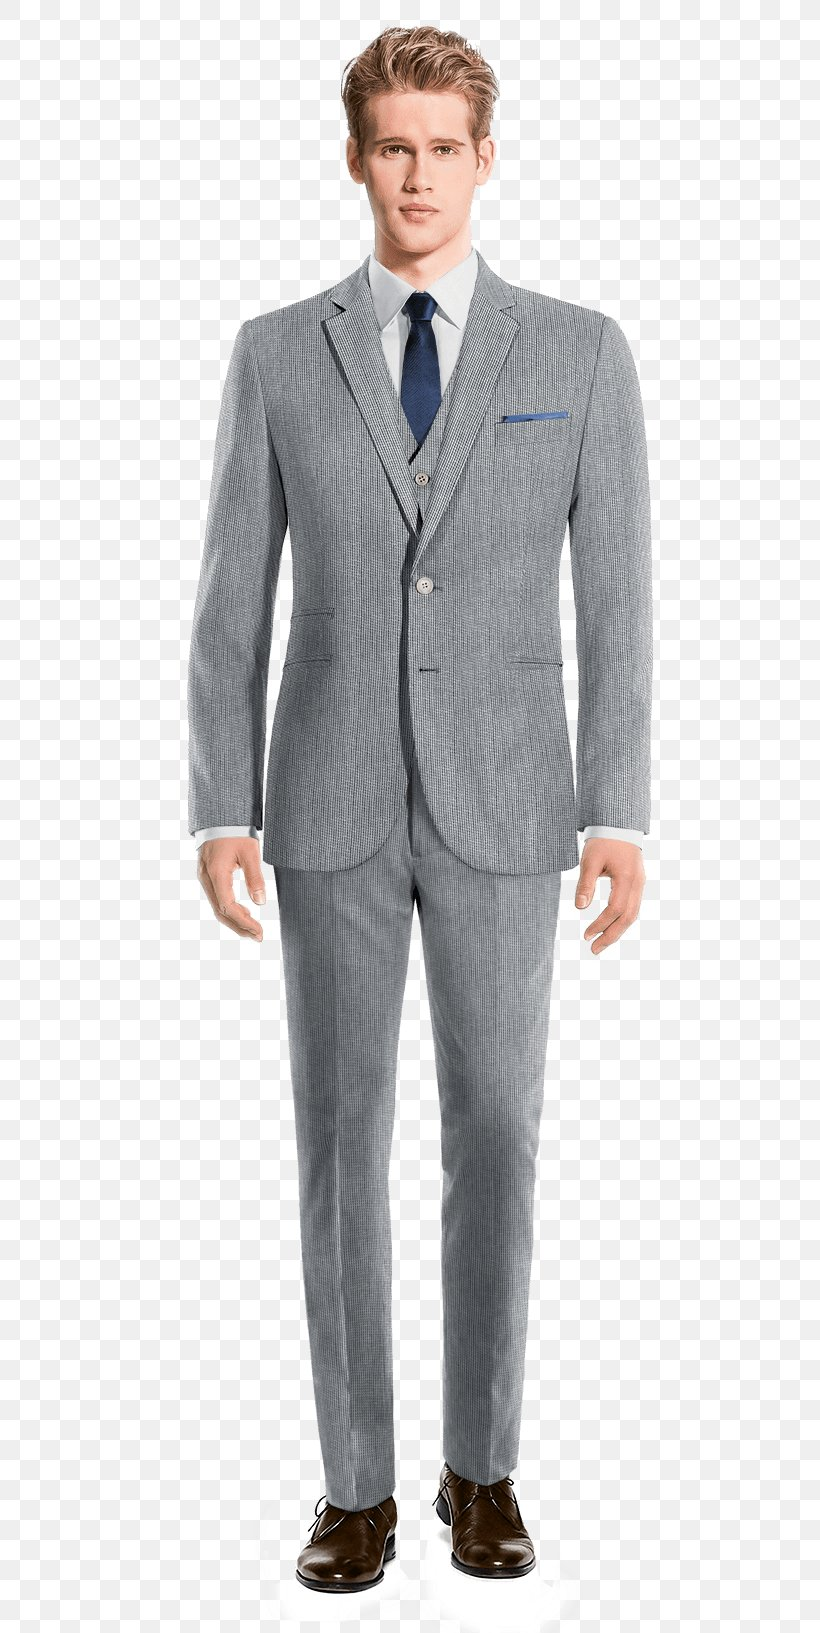

In [ ]:
from diffusers.utils import load_image
from controlnet_aux import OpenposeDetector
import urllib.request
from io import BytesIO
import cv2
from PIL import Image
import numpy as np
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch
from diffusers import UniPCMultistepScheduler


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid



urllib.request.urlretrieve(
  'https://firebasestorage.googleapis.com/v0/b/grid-5-software.appspot.com/o/reference%20image.jpg?alt=media',
   "reference.jpg")

image = Image.open("reference.jpg")
ogImage = image
image




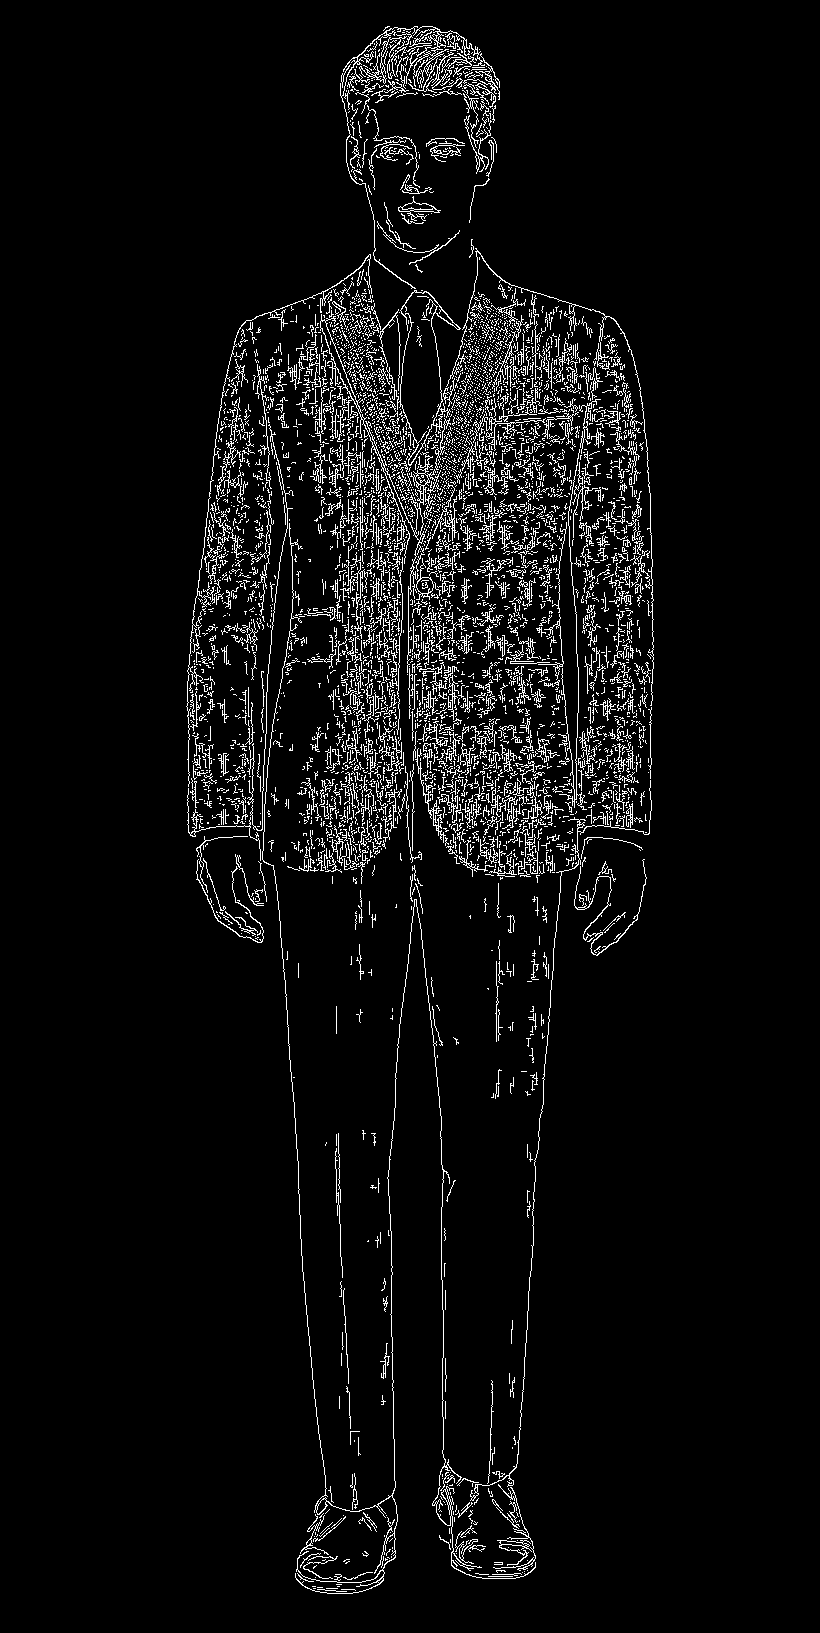

In [ ]:
image = np.array(image)
low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


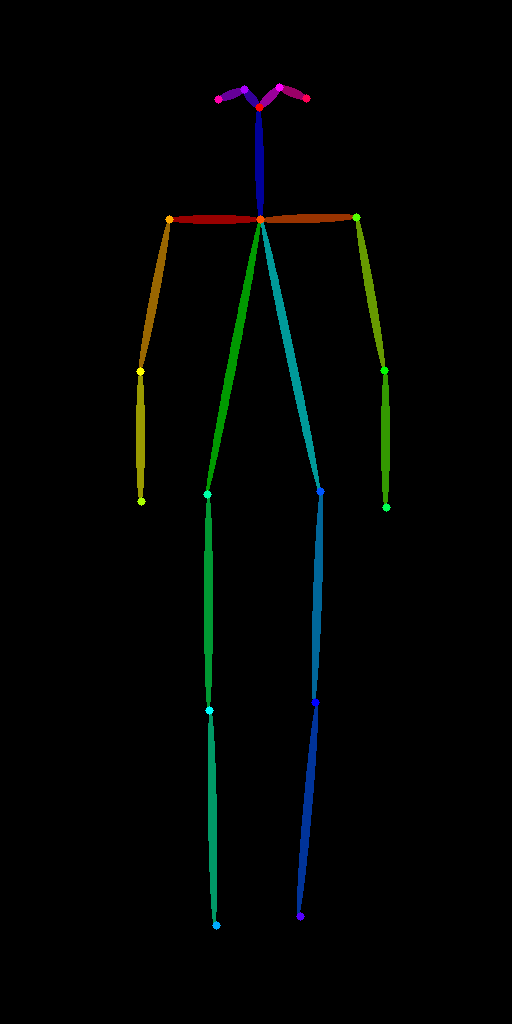

In [ ]:
controlnet = ControlNetModel.from_pretrained("fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
pose = model(ogImage)
pose

  0%|          | 0/20 [00:00<?, ?it/s]

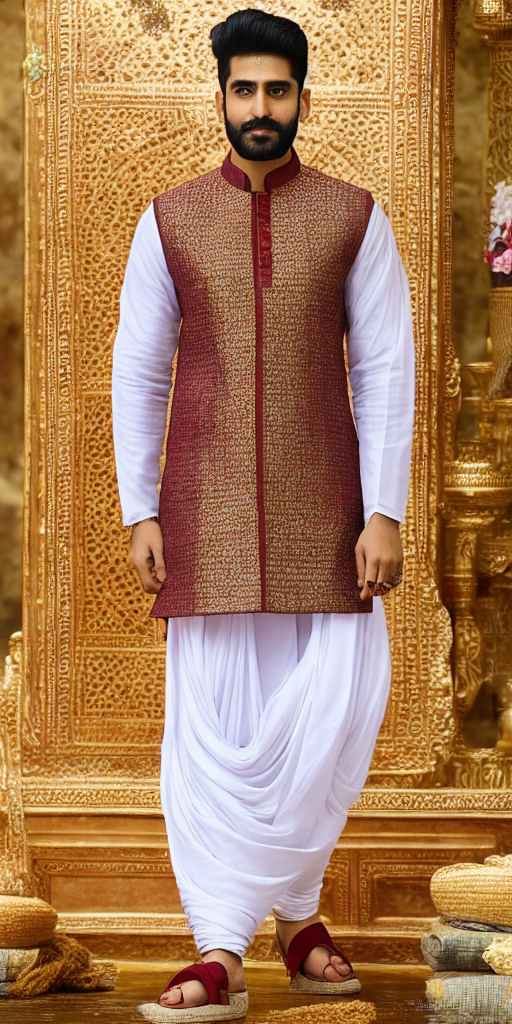

In [ ]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()

pipe.enable_xformers_memory_efficient_attention()

prompt = "Indian Kurta and Dhothi, best quality, extremely detailed"
# prompt = [t + prompt for t in ["Sandra Oh", "Kim Kardashian", "rihanna", "taylor swift"]]
generator = torch.Generator(device="cpu").manual_seed(2)

output = pipe(
    prompt,
    # canny_image,
    pose,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
    num_inference_steps=20,
    generator=generator,
)

output.images[0]